In [54]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from catboost import Pool, cv
from sklearn import datasets
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [55]:
with open('data/vin_ford_train.txt') as f:
    data = f.read()

Допустимые символы в vin

In [56]:
allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Создадим регулярные выражения для парсинга сета

In [57]:
wmi_re = f'(?P<wmi>[{allowed}]{{3}})'
brake  = f'(?P<brake>[{allowed}])'
model  = f'(?P<model>[{allowed}]{{3}})'
engine = f'(?P<engine>[{allowed}])'
check  = f'(?P<check>[{allowed}])'
year   = f'(?P<year>[{allowed}])'
plant  = f'(?P<plant>[{allowed}])'
num    = f'(?P<num>[{allowed}]{{3}}\\d{{3}})'
price  = f':(?P<price>\\d+)'

In [58]:
vin = f'{wmi_re}{brake}{model}{engine}{check}{year}{plant}{num}{price}'
vin_re = re.compile(vin)


In [59]:
def get_dataframe(string_re):
    return pd.DataFrame([x.groupdict() for x in vin_re.finditer(string_re)])

Получим датасет

In [60]:
df = get_dataframe(data)
df.head()

,wmi,brake,model,engine,check,year,plant,num,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   num     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


Приведем типы данных

In [62]:
df['price'] = df['price'].astype('int64')
df[df.columns.difference(['price'])] = df[df.columns.difference(['price'])].astype('str')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   num     71884 non-null  object
 8   price   71884 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 4.9+ MB


Анализ данных

In [64]:
len(df['model'].unique())

365

In [65]:
len(df['num'].unique())

68215

Построим гистограммы

In [66]:
columns_hist = list(df.columns)
columns_hist.remove('num')
columns_hist

['wmi', 'brake', 'model', 'engine', 'check', 'year', 'plant', 'price']

wmi


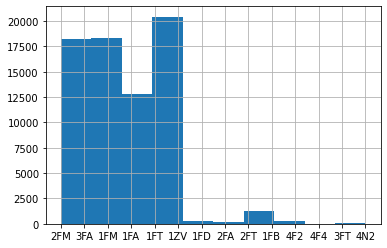

brake


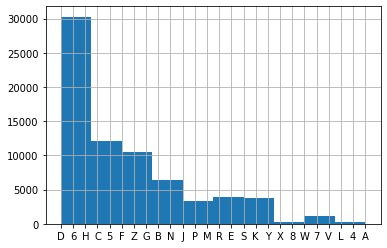

model


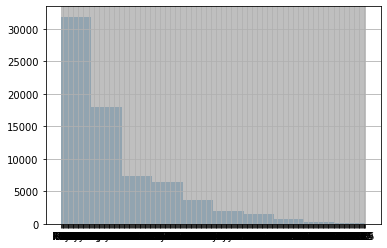

engine


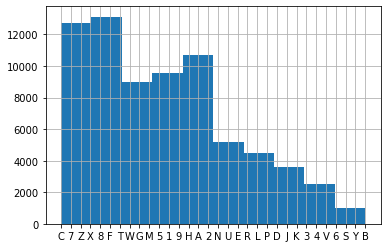

check


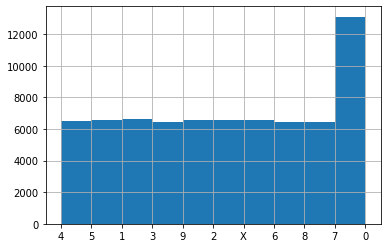

year


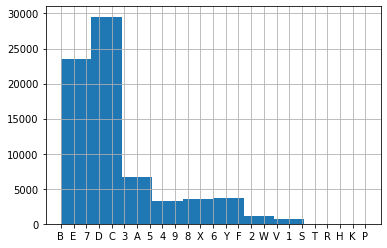

plant


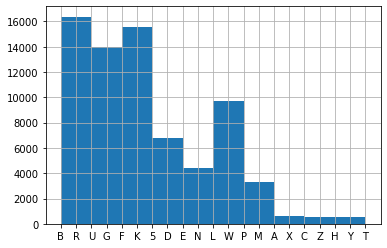

price


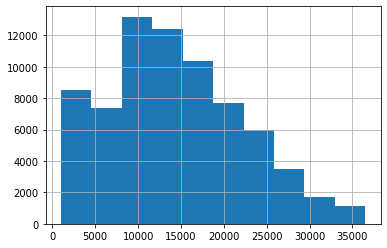

In [67]:
for column in columns_hist:
    print(column)
    df[f'{column}'].hist()
    plt.show()

Построим модель

In [68]:
y = df['price']
X = df.drop(['price', 'num'], axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [70]:
model = CatBoostRegressor(cat_features  = list(X.columns), verbose = False)
                          

In [71]:
parameters = {'depth'         : [5, 6],
              'learning_rate' : [0.2, 0.05],
              'iterations'    : [500, 1000]
             }

In [72]:
grid_searh = GridSearchCV(estimator  = model,
                          param_grid = parameters, 
                          cv         = 4,
                          n_jobs     = -1,
                          scoring = {'rmse' :'neg_root_mean_squared_error',
                                     'mape' :'neg_median_absolute_error'},
                          refit      = 'rmse')

grid_searh.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000025EA2A6B550>,
             n_jobs=-1,
             param_grid={'depth': [5, 6], 'iterations': [500, 1000],
                         'learning_rate': [0.2, 0.05]},
             refit='rmse',
             scoring={'mape': 'neg_median_absolute_error',
                      'rmse': 'neg_root_mean_squared_error'})

Посмотрим результаты

In [73]:
print("Результаты:\n")
print("Лучший RMSE score:\n", round(max(grid_searh.cv_results_['mean_test_rmse'])*(-1)))
print("Лучший MAPE score:\n", round(max(grid_searh.cv_results_['mean_test_mape'])*(-1)))
print("\nЛучшие гиперпараметры:\n", grid_searh.best_params_)

Результаты:

Лучший RMSE score:
 2790
Лучший MAPE score:
 1409

Лучшие гиперпараметры:
 {'depth': 5, 'iterations': 1000, 'learning_rate': 0.2}


Получим лучшую модель и посмотрим feature importance

In [74]:
best_model = grid_searh.best_estimator_

In [75]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,year,34.379299
1,model,19.735267
2,engine,14.326304
3,plant,12.315391
4,brake,9.491535
5,wmi,8.800939
6,check,0.951265


Вывод: Мы разпарсили сырые данные с помощью регулярных выражений, получили датасет и построили модель, которая расчитывает цену автомобиля по его vin номеру. Наилучшая модель показала rmse = 2790 и показала, что наибольший вклад из параметров вносит year и model, а наименьшую check